<a href="https://colab.research.google.com/github/ambgeo/geoquantificacao/blob/main/04_Machine_Learning_KMeans_Sentinel2_Clusters.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🤖 Classificação de Imagens no GEE com K-Means (Sentinel-2)

**Fluxo desta aula:**
1) Autenticação  
2) Definição da área de estudo (ROI desenhada no `geemap`)  
3) Sentinel-2 SR *Harmonized* + máscara de nuvem via **SCL**  
4) Selecionar a **imagem com menor percentual de nuvem**  
5) Aplicar **K-Means (4 clusters)** usando `ee.Clusterer.wekaKMeans`  
6) Criar um **scatterplot** (NIR × Red)  
7) Exportar **imagem classificada** e **imagem multibanda (B2,B3,B4,B8)**  
8) Abrir os **GeoTIFFs** e comparar: **à esquerda RGB** e **à direita os clusters**  

> Observação: exportações locais usam `geemap.ee_export_image`. Há células opcionais para Google Drive.

## 1) Autenticação

In [2]:
import ee
try:
    ee.Authenticate()
except Exception as e:
    print('Se já autenticou anteriormente nesta máquina, pode ignorar este aviso:', e)
ee.Initialize(project='ee-scriptsambgeo')
print('GEE inicializado!')

GEE inicializado!


## 2) Definição da área de estudo (ROI)
1. Execute a célula do mapa.
2. Desenhe um **polígono** com a ferramenta **Draw**.
3. Execute a célula de captura da ROI.

In [ ]:
# !pip -q install geemap folium ipyleaflet
import geemap
Map = geemap.Map(center=[-15, -55], zoom=4)
Map.addLayerControl()
Map

In [ ]:
# Captura a ROI desenhada pelo usuário
roi = Map.user_roi
Map.centerObject(roi, 11)
Map.addLayer(roi, {"color":"red"}, 'ROI')
print('ROI definida!')
Map

## 3) Sentinel-2 SR (Harmonized) e máscara de nuvem com SCL
- Coleção: **`COPERNICUS/S2_SR_HARMONIZED`** (reflectância de superfície, escala 0–10000).  
- Máscara via **SCL** (Scene Classification Layer): remove **cloud shadow (3)**, **clouds (8,9,10)** e **snow/ice (11)**.  
- Convertemos bandas ópticas para **0–1** (÷10000).

In [10]:
def mask_s2_scl(img):
    scl = img.select('SCL')
    valid = (scl.neq(3).And(scl.neq(8)).And(scl.neq(9)).And(scl.neq(10)).And(scl.neq(11)))
    scaled = img.select(['B2','B3','B4','B8','B11','B12']).divide(10000)
    return img.addBands(scaled, None, True).updateMask(valid)

## 4) Seleção da imagem com menor percentual de nuvem

In [ ]:
s2 = (ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
      .filterBounds(roi)
      .filterDate('2025-01-01', '2025-07-01')
      .sort('CLOUDY_PIXEL_PERCENTAGE'))
best = mask_s2_scl(ee.Image(s2.first())).clip(roi)

print('Imagem:', best.get('PRODUCT_ID').getInfo())
print('Data  :', ee.Date(best.get('system:time_start')).format('YYYY-MM-dd').getInfo())
print('Cloud :', best.get('CLOUDY_PIXEL_PERCENTAGE').getInfo())

viz_rgb = {"bands": ['B4','B3','B2'], "min": 0.0, "max": 0.3}
viz_nir = {"bands": ['B8','B4','B3'], "min": 0.0, "max": 0.3}
Map.addLayer(best, viz_rgb, 'S2 RGB (true color)')
Map.addLayer(best, viz_nir, 'S2 NIR (8-4-3)')
Map

## 5) K-Means (4 clusters)
Amostra pixels espectrais na ROI, treina `wekaKMeans(4)` e clusteriza a imagem.

In [ ]:
bands = ['B2','B3','B4','B8','B11','B12']
training = best.select(bands).sample(region=roi, scale=10, numPixels=5000, seed=42)
clusterer = ee.Clusterer.wekaKMeans(4).train(training)
clusters = best.select(bands).cluster(clusterer).rename('kmeans').clip(roi)
palette = ['#1f78b4','#33a02c','#e31a1c','#ff7f00']
Map.addLayer(clusters, {"min":0, "max":3, "palette":palette}, 'Clusters (0–3)')
Map

## 6) Scatterplot NIR × Red

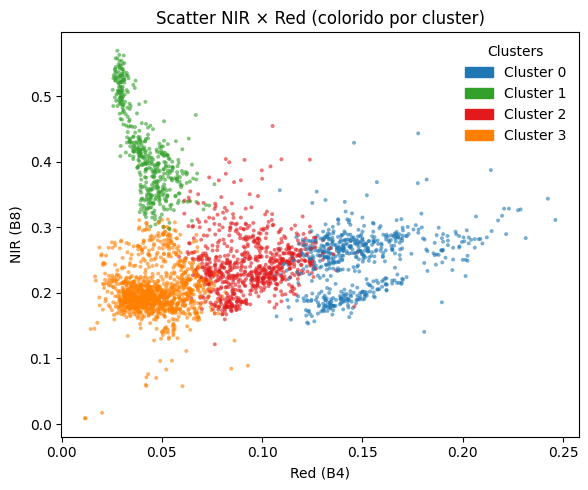

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 1) Amostrar B8, B4 e a banda de clusters (assume que 'clusters' já foi criado)
stack = best.select(['B8','B4']).addBands(clusters.rename('cluster'))
sample_for_plot = stack.sample(region=roi, scale=10, numPixels=3000, seed=13, geometries=False)

# 2) Para DataFrame
df_plot = pd.DataFrame([f['properties'] for f in sample_for_plot.getInfo()['features']]).dropna()
df_plot['cluster'] = df_plot['cluster'].astype(int)

# 3) Paleta discreta (uma cor por cluster)
palette = {0:'#1f78b4', 1:'#33a02c', 2:'#e31a1c', 3:'#ff7f00'}  # azul, verde, vermelho, laranja
colors = df_plot['cluster'].map(palette)

# 4) Scatter colorido por cluster
plt.figure(figsize=(6,5))
plt.scatter(df_plot['B4'], df_plot['B8'], c=colors, s=8, alpha=0.6, edgecolors='none')
plt.xlabel('Red (B4)')
plt.ylabel('NIR (B8)')
plt.title('Scatter NIR × Red (colorido por cluster)')

# 5) Legenda manual
import matplotlib.patches as mpatches
handles = [mpatches.Patch(color=palette[k], label=f'Cluster {k}') for k in sorted(palette.keys())]
plt.legend(handles=handles, title='Clusters', frameon=False, loc='best')

plt.tight_layout()
plt.show()


## 7) Exportar: imagem classificada e multibanda (local ou Drive)

In [16]:
# import geemap
# geemap.ee_export_image(clusters, filename='s2_kmeans4.tif', scale=10, region=roi, file_per_band=False)
# geemap.ee_export_image(best.select(['B2','B3','B4','B8']), filename='s2_B2_B3_B4_B8.tif', scale=10, region=roi, file_per_band=False)
# print('✔ Export local: s2_kmeans4.tif + s2_B2_B3_B4_B8.tif')

# Drive (opcional)
task = ee.batch.Export.image.toDrive(image=clusters, description='s2_kmeans4',folder='Geoquanti', fileNamePrefix='s2_kmeans4', region=roi.getInfo()['coordinates'], scale=10, maxPixels=1e13);
task.start()

In [17]:
# Drive (opcional)
task = ee.batch.Export.image.toDrive(image=best.select(['B2','B3','B4','B8']), description='s2_B2_B3_B4_B8',folder='Geoquanti', fileNamePrefix='s2_B2_B3_B4_B8', region=roi.getInfo()['coordinates'], scale=10, maxPixels=1e13);
task.start()

## 8) Comparativo local: RGB × Clusters (lado a lado)

In [19]:
!pip install rasterio -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 36.4 MB/s eta 0:00:00


In [20]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


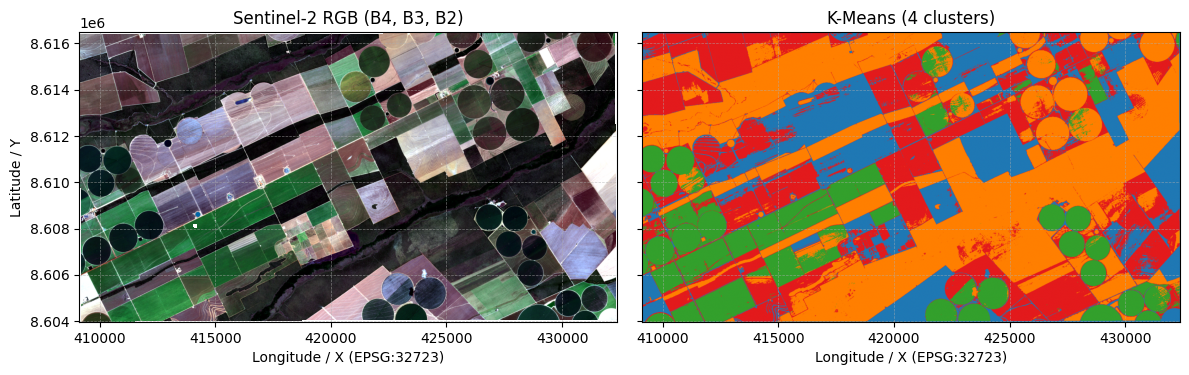

In [22]:
import rasterio as rio
import numpy as np
import matplotlib.pyplot as plt

# --- caminhos dos GeoTIFFs (RGB e clusters) ---
rgb_path = '/content/drive/MyDrive/Geoquanti/s2_B2_B3_B4_B8.tif'
cls_path = '/content/drive/MyDrive/Geoquanti/s2_kmeans4.tif'

# ---------- 1) Ler a imagem RGB (B4,B3,B2) e aplicar um stretch ----------
with rio.open(rgb_path) as src_rgb:
    # Lê as bandas na ordem para RGB verdadeiro: B4, B3, B2
    rgb = src_rgb.read([3, 2, 1]).astype('float32')  # shape (C, H, W)

    # Função de stretch (2–98%) para melhorar contraste
    def stretch(b):
        lo, hi = np.percentile(b[np.isfinite(b)], (2, 98))
        return np.clip((b - lo) / (hi - lo + 1e-6), 0, 1)

    # Aplica stretch banda a banda e reempilha no formato (H, W, 3)
    rgb = np.stack([stretch(rgb[0]), stretch(rgb[1]), stretch(rgb[2])], axis=-1)

    # Extent (coordenadas reais) a partir dos bounds do raster
    left, bottom, right, top = src_rgb.bounds
    extent = [left, right, bottom, top]

    # CRS (só para rotular os eixos)
    crs_str = src_rgb.crs.to_string() if src_rgb.crs is not None else "desconhecido"

# ---------- 2) Ler a imagem de clusters ----------
with rio.open(cls_path) as src_cls:
    cls = src_cls.read(1)

# Paleta para 4 clusters (0..3)
palette = np.array([
    [31/255, 120/255, 180/255],  # azul
    [51/255, 160/255,  44/255],  # verde
    [227/255, 26/255,  28/255],  # vermelho
    [255/255, 127/255,  0/255],  # laranja
])

# Converte o raster de rótulos para um RGB usando a paleta
cls_rgb = palette[np.clip(cls, 0, 3)]

# ---------- 3) Plot lado a lado com grid e coordenadas via extent ----------
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)

# Painel esquerdo: RGB verdadeiro
im0 = axes[0].imshow(
    rgb,
    extent=extent,        # usa coordenadas reais (lon/lat ou metros, conforme CRS)
    origin='upper'        # mantém orientação espacial correta
)
axes[0].set_title('Sentinel-2 RGB (B4, B3, B2)')
axes[0].set_xlabel(f'Longitude / X ({crs_str})')
axes[0].set_ylabel('Latitude / Y')
axes[0].grid(True, linestyle='--', linewidth=0.5, alpha=0.6)

# Painel direito: Clusters (K-Means)
im1 = axes[1].imshow(
    cls_rgb,
    extent=extent,        # mesmo extent do RGB para alinhar
    origin='upper'
)
axes[1].set_title('K-Means (4 clusters)')
axes[1].set_xlabel(f'Longitude / X ({crs_str})')
axes[1].grid(True, linestyle='--', linewidth=0.5, alpha=0.6)

# Ajuste de layout
plt.tight_layout()
plt.show()
